In [1]:
from typing import Optional, Tuple, List, Dict, Any, Union
import os
from pathlib import Path
import numpy as np
from glob import glob
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle


import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification import BinaryJaccardIndex
import segmentation_models_pytorch as smp

In [2]:
class GeoImageDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = os.listdir(self.img_dir)
        self.mask_files = os.listdir(self.mask_dir)
        # self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        # mask and img_file have so far the same name
        mask_path = os.path.join(self.mask_dir, self.img_files[idx])
        img = torch.load(img_path)
        # converts bool mask into integer (0/1)
        mask = torch.load(mask_path).long()
        # Apply transform (if any)
        # if self.transform:
        #     img = self.transform(img)

        return img, mask

In [3]:
def train(
    dataloader: Any,
    model: nn.Module,
    loss_fn: Any,
    optimizer: Any,
) -> Union[torch.Tensor, List[float]]:
    size = len(dataloader.dataset)
    loss_vals=  []
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        
        loss = loss_fn(pred.squeeze(1), y.to(torch.float32))
        loss_vals.append(loss.item())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = np.mean(loss_vals)
    return avg_loss, loss_vals

In [32]:
def test(dataloader: Any, model: nn.Module, loss_fn: Any) -> Union[torch.Tensor, torch.Tensor, List[float]]:
    loss_vals=  []
    jaccard_idx_vals = []
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0

    metric = BinaryJaccardIndex().to(device)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred.squeeze(1), y.to(torch.float32)).item()
            test_loss += loss
            IoU = metric(pred, y)
            if torch.isnan(IoU):
                IoU = torch.from_numpy(np.nan_to_num(IoU.numpy()))
            loss_vals.append(loss)
            test_IoU =+ IoU.item()
            jaccard_idx_vals.append(IoU.item())

    test_loss /= num_batches
    test_IoU /= num_batches
    # correct /= size

    # jaccard_idx = 100 * metric(pred, y)
    print(
        f"Test Error: \n"
        f"Jaccard-Index: {(test_IoU*100):>0.3f}%, Avg loss: {test_loss:>5f} \n"
    )

    return test_loss, loss_vals, test_IoU, jaccard_idx_vals

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
root = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection")

train_images_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling\train\images")
train_masks_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling\train\masks")
val_images_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling\val\images")
val_masks_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling\val\masks")
test_images_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling\test\images")
test_masks_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling\test\masks")

In [7]:
train_dataset = GeoImageDataset(train_images_path, train_masks_path)
val_dataset = GeoImageDataset(val_images_path, val_masks_path)
test_dataset = GeoImageDataset(test_images_path, test_masks_path)

In [8]:
batch_size = 16
shuffle = True

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [9]:
print(f"Size train set: {train_dataset.__len__()}")
print(f"Size val set: {val_dataset.__len__()}")
print(f"Size test set: {test_dataset.__len__()}")

Size train set: 14178
Size val set: 4648
Size test set: 1857


In [34]:
model = smp.Unet(
    encoder_name='efficientnet-b0',
    encoder_weights='imagenet',
    in_channels=4,
    classes=1,
    activation='sigmoid',
).to(device)

In [35]:
epochs = 5
max_lr = 0.001

optimizer = Adam(model.parameters(), lr=max_lr)

scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_dataloader),epochs=epochs)

loss_fn = smp.losses.DiceLoss(mode="binary", log_loss=False, from_logits=False)

In [36]:
train_loss_vals = []
val_loss_vals = []
val_jaccard_idx_vals = []

train_loss_single = []
val_loss_single = []
val_jaccard_idx_single = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    loss, train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_loss_vals.extend(train_loss)
    train_loss_single.append(loss)
    loss, val_loss, jaccard_idx, jaccard_idx_list  = test(val_dataloader, model, loss_fn)
    val_loss_vals.extend(val_loss)
    val_loss_single.append(loss)
    val_jaccard_idx_single.append(jaccard_idx)
    val_jaccard_idx_vals.extend(jaccard_idx_list)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
loss: 0.992973  [   16/14178]
loss: 0.988648  [  176/14178]
loss: 0.995717  [  336/14178]
loss: 0.994472  [  496/14178]
loss: 0.986501  [  656/14178]
loss: 0.988234  [  816/14178]
loss: 0.994240  [  976/14178]
loss: 0.993316  [ 1136/14178]
loss: 0.988995  [ 1296/14178]
loss: 0.989244  [ 1456/14178]
loss: 0.982944  [ 1616/14178]
loss: 0.989911  [ 1776/14178]
loss: 0.994877  [ 1936/14178]
loss: 0.986949  [ 2096/14178]
loss: 0.993867  [ 2256/14178]
loss: 0.995905  [ 2416/14178]
loss: 0.937179  [ 2576/14178]
loss: 0.985360  [ 2736/14178]
loss: 0.985934  [ 2896/14178]
loss: 0.964425  [ 3056/14178]
loss: 0.988350  [ 3216/14178]
loss: 0.989150  [ 3376/14178]
loss: 0.967574  [ 3536/14178]
loss: 0.995513  [ 3696/14178]
loss: 0.922192  [ 3856/14178]
loss: 0.991005  [ 4016/14178]
loss: 0.967725  [ 4176/14178]
loss: 0.975843  [ 4336/14178]
loss: 0.995812  [ 4496/14178]
loss: 0.989478  [ 4656/14178]
loss: 0.975937  [ 4816/14178]
loss: 0.932122  [ 4976/14178]


In [37]:
print('train_loss_vals: ', len(train_loss_vals))
print('val_loss_vals: ', len(val_loss_vals))
print('val_jaccard_idx_vals: ', len(val_jaccard_idx_vals))

train_loss_vals:  4435
val_loss_vals:  1455
val_jaccard_idx_vals:  1455


In [227]:
#save model
torch.save(model.state_dict(), root/'Notebooks/ML_Modell/models/model_efficientnet_b0_undersampling_raw.pt')

#### Train Loss

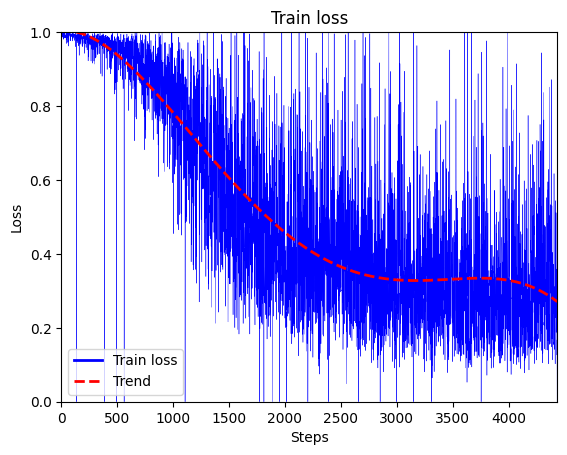

In [38]:
epochs = range(1, len(train_loss_vals) + 1)

# Add trend curve
z_jaccard = np.polyfit(epochs, train_loss_vals, 4)
p_jaccard = np.poly1d(z_jaccard)
plt.plot(train_loss_vals, 'b', label='Train loss', linewidth=0.3)
plt.plot(epochs, p_jaccard(epochs), "r--", label='Trend', linewidth=2)

plt.title('Train loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.xlim(0, len(train_loss_vals))
plt.ylim(0, 1)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

#### Validation Loss

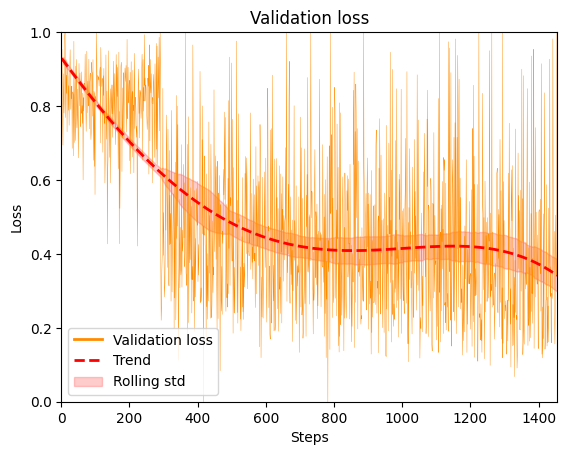

In [39]:
epochs = range(1, len(val_loss_vals) + 1)
orange = '#FF8C00'
# Add trend curve
z_jaccard = np.polyfit(epochs, val_loss_vals, 4)
p_jaccard = np.poly1d(z_jaccard)

plt.plot(val_loss_vals, color=orange, label='Validation loss', linewidth=0.3)
plt.plot(epochs, p_jaccard(epochs), "r--", label='Trend',  linewidth=2)

window_size = 200
rolling_std = pd.Series(val_loss_vals).rolling(window_size, min_periods=1).var().values

plt.fill_between(epochs, p_jaccard(epochs)-rolling_std, p_jaccard(epochs)+rolling_std, alpha=0.2, color='red', label='Rolling std')

plt.title('Validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')

plt.xlim(0, len(val_loss_vals))
plt.ylim(0, 1)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

#### Jaccard Index (IoU)

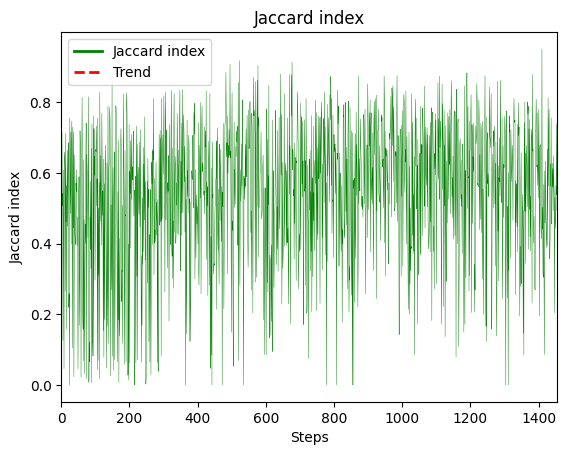

In [19]:
epochs = range(1, len(val_jaccard_idx_vals) + 1)

# Add trend curve
z_jaccard = np.polyfit(epochs, val_jaccard_idx_vals, 4)
p_jaccard = np.poly1d(z_jaccard)
plt.plot(val_jaccard_idx_vals, 'g', label='Jaccard index', linewidth=0.3)
plt.plot(epochs, p_jaccard(epochs), "r--", label='Trend', linewidth=2)

plt.title('Jaccard index')
plt.xlabel('Steps')
plt.ylabel('Jaccard index')
plt.xlim(0, len(val_jaccard_idx_vals))
# plt.ylim(0, 1)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

#### Combine Validation Loss and Jaccard Index (IoU) in one plot

not used in the paper

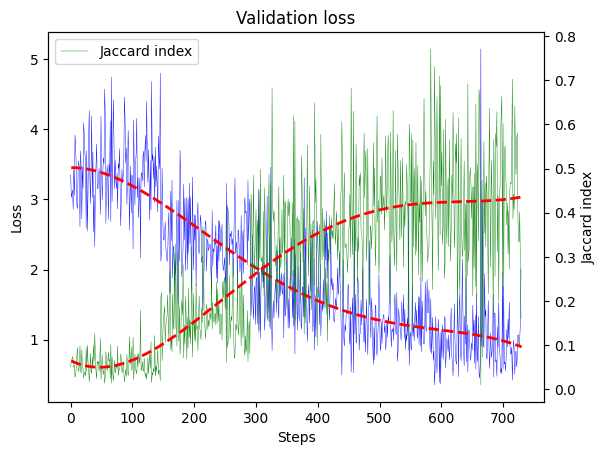

In [18]:
epochs = range(1, len(val_jaccard_idx_vals) + 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
z_loss = np.polyfit(epochs, val_loss_vals, 4)
p_loss= np.poly1d(z_loss)
ax1.plot(val_loss_vals, 'b', label='Validation loss', linewidth=0.3, zorder=1)

ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')


z_jaccard = np.polyfit(epochs, val_jaccard_idx_vals, 4)
p_jaccard = np.poly1d(z_jaccard)
ax2.plot(val_jaccard_idx_vals, 'g', label='Jaccard index', linewidth=0.3, zorder=2)

ax1.plot(epochs, p_loss(epochs), "r--", linewidth=2, zorder=10)
ax2.plot(epochs, p_jaccard(epochs), "r--", linewidth=2, zorder=10)

ax2.set_ylabel('Jaccard index')
plt.title('Validation loss')
plt.xlabel('Steps')
plt.legend()
plt.show()

### Create plot on epoch level

In [29]:
# is still on the GPU
val_jaccard_idx_single

[tensor(0.1014, device='cuda:0'),
 tensor(0.5322, device='cuda:0'),
 tensor(0.6770, device='cuda:0'),
 tensor(0.4184, device='cuda:0'),
 tensor(0.5845, device='cuda:0'),
 tensor(0.6977, device='cuda:0'),
 tensor(0.6340, device='cuda:0'),
 tensor(0.3410, device='cuda:0'),
 tensor(0.4403, device='cuda:0'),
 tensor(0.7562, device='cuda:0')]

In [21]:
val_jaccard_idx_single_cpu = [tensor.detach().cpu().numpy().mean() for tensor in val_jaccard_idx_single]

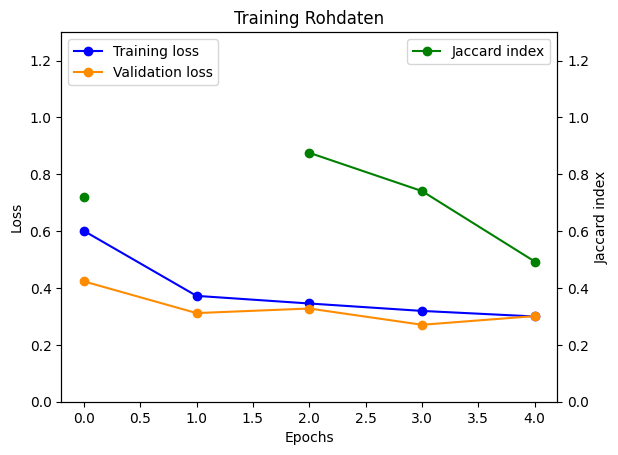

In [23]:
epochs = range(1, len(train_loss_single) + 1)
orange = '#FF8C00'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(train_loss_single, 'b-o', label='Training loss')
ax1.plot(val_loss_single, '-o', color=orange, label='Validation loss')
ax2.plot(val_jaccard_idx_single_cpu, 'g-o', label='Jaccard index')
plt.title('Training Rohdaten')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('Jaccard index')
# plt.xlim(0, len(train_loss_single))
ax1.set_ylim(0, 1.3)
ax2.set_ylim(0, 1.3)
# plt.legend()
plt.show()

In [32]:
df = pd.DataFrame({'train_loss': train_loss_single, 'test_loss': val_loss_single, 'jaccard': val_jaccard_idx_single_cpu})
df

,train_loss,test_loss,jaccard
0,4.142360,2.886527,0.101373
1,2.275473,1.287333,0.532182
2,1.124259,0.869268,0.677000
3,0.795815,0.742781,0.418406
4,0.619940,0.745305,0.584521
5,0.537826,0.658911,0.697723
6,0.561809,0.625285,0.634036
7,0.466811,0.799447,0.341030
8,0.472077,0.551344,0.440258
9,0.426264,0.687182,0.756196


In [33]:
df.to_csv('loss_epochs_10_raw.csv', index=False)

In [34]:
with open('loss_steps_epochs_10_raw.pkl', 'wb') as f:
    pickle.dump([train_loss_vals, val_loss_vals, val_jaccard_idx_vals], f)

In [145]:
# Laden der Listen aus der Datei
with open('loss_steps_epochs_2.pkl', 'rb') as f:
    loaded_lists = pickle.load(f)

Create plotting function to save it easily

In [23]:
def plot_figure(data, data_label, xlabel, ylabel, ax=ax1, color='blue', xlim=None, ylim=None, legend=True, trend=False, trend_label='Trend', marker='-', linewidth=1):  
    epochs = range(1, len(data) + 1)

    # Add trend curve
    z_data = np.polyfit(epochs, data, 4)
    p_data = np.poly1d(z_data)
    ax.plot(data, marker, color=color, label=data_label, linewidth=linewidth)
    if trend:
        ax.plot(epochs, p_data(epochs), "r--", label=trend_label, linewidth=2)

    # ax.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, len(data))
    if ylim != None:
        ax.set_xlim(0, ylim)


    if legend:
        leg = ax.legend()
        for line in leg.get_lines():
            line.set_linewidth(2)

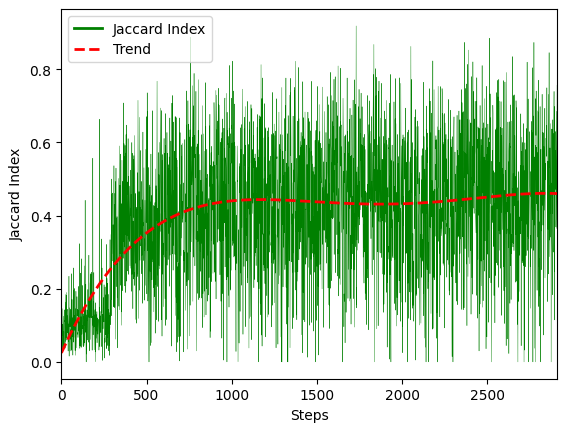

In [162]:
fig, ax1 = plt.subplots()
plot_figure(val_jaccard_idx_vals, 'Jaccard Index', 'Steps', 'Jaccard Index',ax=ax1, color='g',trend=True, linewidth=0.3)

(0.0, 1.3)

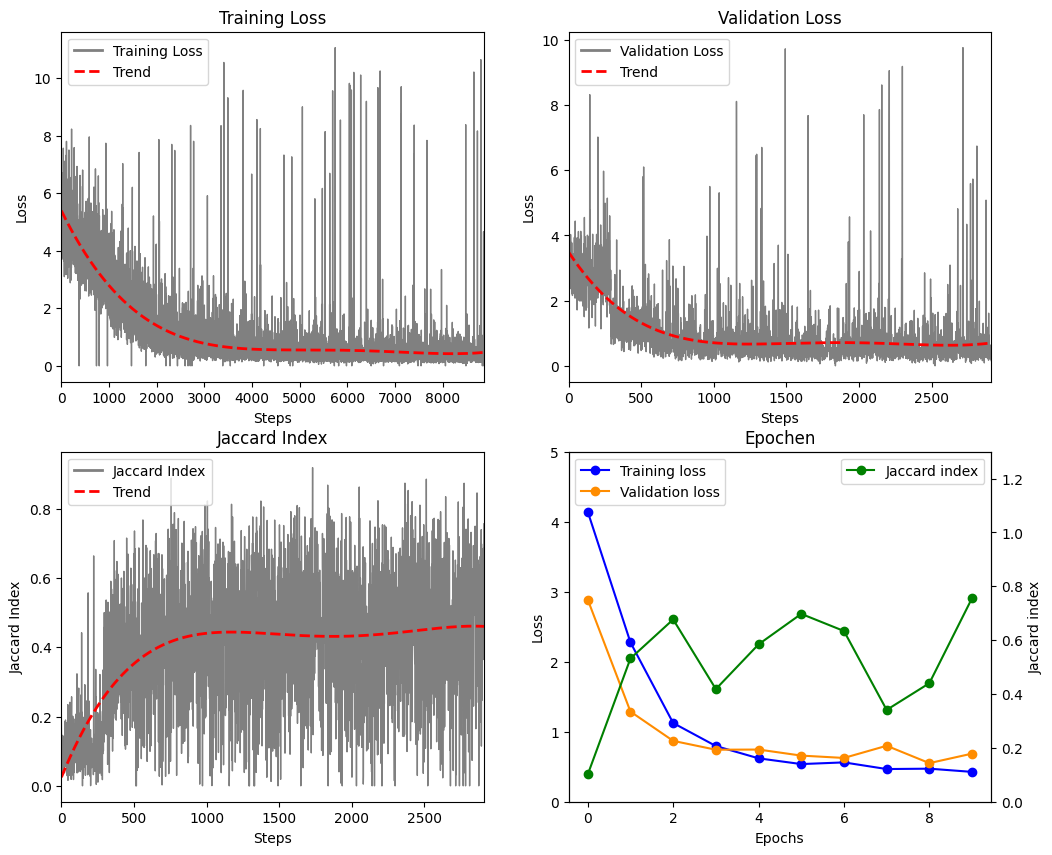

In [223]:
orange = '#FF8C00'
gray = '#808080'
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(2,2, figsize=(12, 10))
train_plot = plot_figure(train_loss_vals, 'Training Loss', 'Steps', 'Loss', ax=axs[0, 0], color=gray, trend=True)
axs[0, 0].set_title('Training Loss')
loss_plot = plot_figure(val_loss_vals, 'Validation Loss', 'Steps', 'Loss', ax=axs[0, 1], color=gray, trend=True)
axs[0, 1].set_title('Validation Loss')
jaccard_plot = plot_figure(val_jaccard_idx_vals, 'Jaccard Index', 'Steps', 'Jaccard Index', ax=axs[1, 0], color=gray, trend=True)
axs[1, 0].set_title('Jaccard Index')

ax4a = axs[1, 1]
ax4b = ax4a.twinx()
axs[1, 1].set_title('Epochen')
ax4a.plot(train_loss_single, 'b-o', label='Training loss')
ax4a.plot(val_loss_single, '-o', color=orange, label='Validation loss')

# ax4 = ax3.twinx()
ax4b.plot(val_jaccard_idx_single_cpu, 'g-o', label='Jaccard index')
ax4a.set_xlabel('Epochs')
ax4a.set_ylabel('Loss')
ax4b.set_ylabel('Jaccard index')
ax4a.legend(loc='upper left')
ax4b.legend(loc='upper right')
ax4a.set_ylim(0, 5)
ax4b.set_ylim(0, 1.3)

In [225]:
# save figure
fig.savefig('figures/raw_data/training_raw_grid_gray.pdf', bbox_inches='tight')

### Test set 

In [21]:
test_loss_vals = []
test_jaccard_idx_vals = []

test_loss_single = []
test_jaccard_idx_single = []

loss, test_loss, jaccard_idx, jaccard_idx_list  = test(test_dataloader, model, loss_fn)
test_loss_vals.extend(test_loss)
test_loss_single.append(loss)
test_jaccard_idx_single.append(jaccard_idx)
test_jaccard_idx_vals.extend(jaccard_idx_list)

Test Error: 
Jaccard-Index: 5.724%, Avg loss: 1.519714 



In [22]:
print(f'Jaccard Index on test set: {round(np.mean(test_jaccard_idx_vals)*100, 2)} %', )

Jaccard Index on test set: 34.59 %


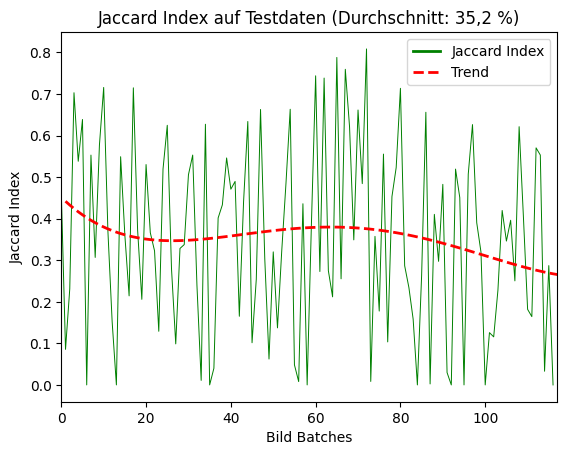

In [212]:
fig, ax1 = plt.subplots()
ax1.set_title('Jaccard Index auf Testdaten (Durchschnitt: 35,24 %)')
plot_figure(test_jaccard_idx_vals, 'Jaccard Index', 'Bild Batches', 'Jaccard Index',ax=ax1, color='g',trend=True, trend_label='Durchschnitt', linewidth=0.7)

In [220]:
fig.savefig('figures/raw_data/test_data_jaccard_raw.pdf', bbox_inches='tight')

#### Check the Validation set on which images the model performs worst (outliers)

Not the test set to prevent data leakage

In [24]:
import rasterio

In [25]:
class GeoImageDataset(Dataset):
    def __init__(self, img_dir: Path, mask_dir:Path, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = os.listdir(self.img_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform = transform
        

    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        # Load image
        img_path = self.img_dir / self.img_files[idx]
        # mask and img_file have so far the same name
        mask_path = self.mask_dir / self.img_files[idx]
        img = torch.load(img_path)
        # converts bool mask into integer (0/1)
        mask = torch.load(mask_path).long()
        # Apply transform (if any)
        if self.transform:
            img = self.transform(img)
        
        return img, mask, img_path, mask_path

In [145]:
val_images_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling\val\images")
val_masks_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling\val\masks")

val_dataset = GeoImageDataset(val_images_path, val_masks_path)

In [144]:
model.eval() # enabling the eval mode to test with new samples.
metric = BinaryJaccardIndex().to(device)

In [146]:
index_list = []
metric_list = []
mask_size_list = []
brightness_image_list = []
img_path_list = []
mask_path_list = []
pred_list = []

for i, sample in enumerate(val_dataset):
    img, mask, img_path, mask_path = val_dataset[i]

    img = img.to(device)
    mask = mask.to(device)
    # Skip images with no mask (jaccard will fail)
    if mask.sum() <= 1:
        continue
    with torch.no_grad():
        pred = model(img.unsqueeze(0))

    IoU = metric(pred[:,0], mask).detach().cpu().numpy()
    index_list.append(i)
    metric_list.append(IoU)
    mask_size_list.append(mask.sum().cpu().numpy())
    brightness_image_list.append(img.mean().cpu().numpy())
    img_path_list.append(img_path)
    mask_path_list.append(mask_path)
    pred_list.append(pred[:,0].detach().cpu().numpy())

df = pd.DataFrame({'index': index_list, 'metric': metric_list, 'mask_size': mask_size_list, 'brightness': brightness_image_list,'pred_mask': pred_list, 'img_path': img_path_list, 'mask_path': mask_path_list})

df = df.sort_values('metric', ascending=False)

df = df.reset_index(drop=True)

df.head()

,index,metric,mask_size,brightness,pred_mask,img_path,mask_path
0,3860,0.9591078,1829,0.3034925,"[[[0.037375767, 0.0077183438, 0.008473204, 0.0...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
1,3840,0.9375385,4620,0.23758888,"[[[0.18851054, 0.15886898, 0.3904268, 0.545922...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
2,4053,0.936,2714,0.23084094,"[[[0.03572957, 0.0075167506, 0.00768276, 0.008...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
3,3878,0.92521846,7622,0.24084537,"[[[0.044657674, 0.014059813, 0.011699027, 0.01...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
4,3861,0.9242986,1829,0.29417557,"[[[0.03551045, 0.008933377, 0.010964849, 0.011...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...


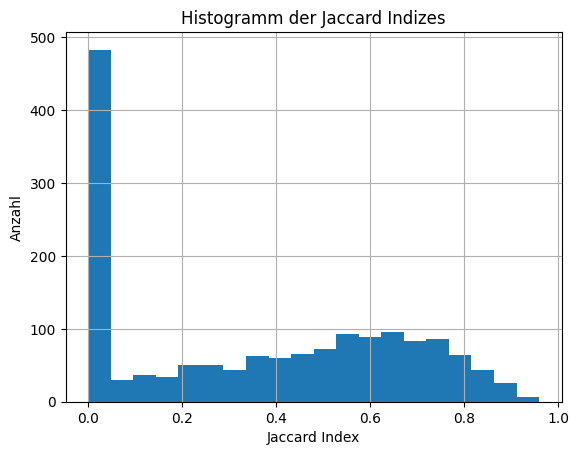

In [152]:
plt.hist(df['metric'], bins=20, )
# add grid
plt.grid(True)
plt.xlabel('Jaccard Index')
plt.ylabel('Anzahl')
plt.title('Histogramm der Jaccard Indizes');

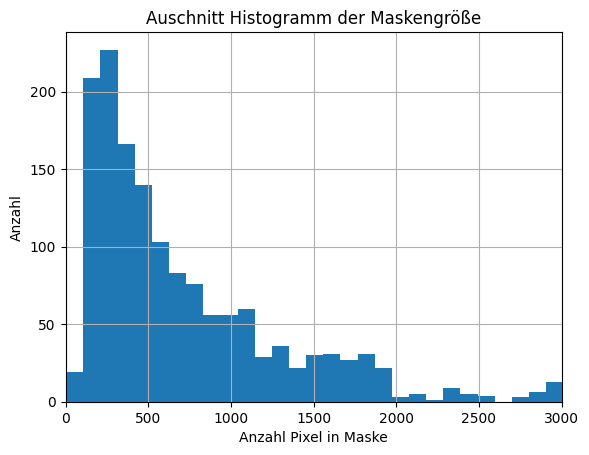

In [163]:
plt.hist(df['mask_size'], bins=200, )
plt.grid(True)
plt.xlim(0, 3000)
plt.xlabel('Anzahl Pixel in Maske')
plt.ylabel('Anzahl')
plt.title('Auschnitt Histogramm der Maskengröße');

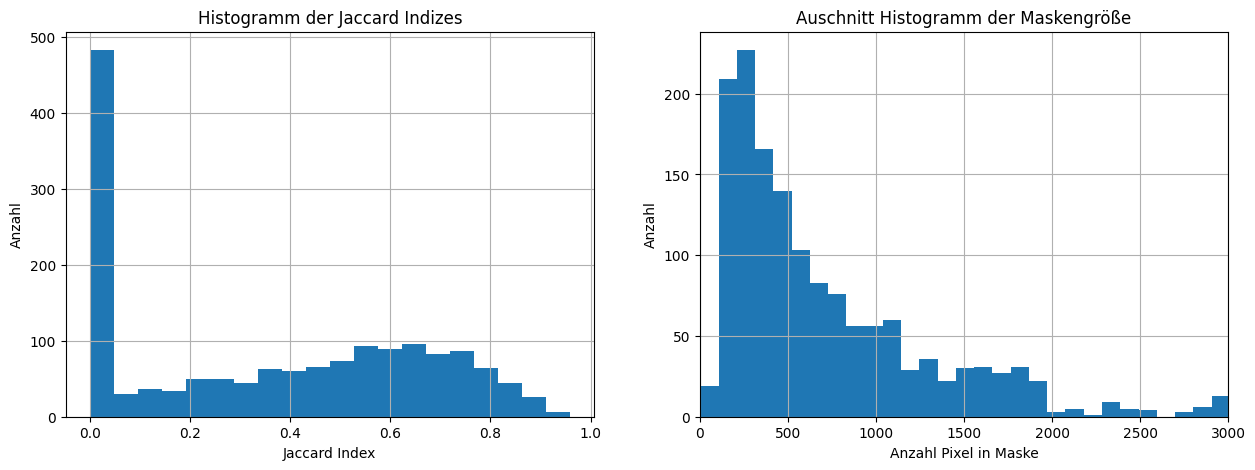

In [170]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(df['metric'], bins=20, )
# add grid
ax1.grid(True)
ax1.set_xlabel('Jaccard Index')
ax1.set_ylabel('Anzahl')
ax1.set_title('Histogramm der Jaccard Indizes');

ax2.hist(df['mask_size'], bins=200, )
ax2.grid(True)
ax2.set_xlim(0, 3000)
ax2.set_xlabel('Anzahl Pixel in Maske')
ax2.set_ylabel('Anzahl')
ax2.set_title('Auschnitt Histogramm der Maskengröße');

In [171]:
fig.savefig('figures/raw_data/histogramm_jaccard_masksize.pdf', bbox_inches='tight')

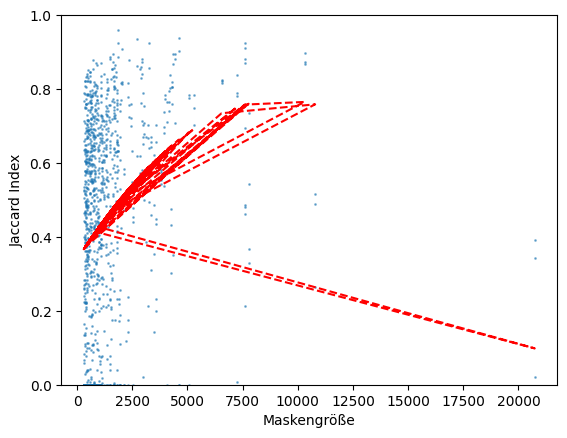

In [110]:

z = np.polyfit(mask_size_list, metric_list, 2)
p = np.poly1d(z)
plt.scatter(mask_size_list, metric_list, s=1, alpha=0.5)
# Zeichnen Sie die Trendlinie
plt.plot(mask_size_list, p(mask_size_list), 'r--')
# Labeln Sie die Achsen
plt.xlabel('Maskengröße')
plt.ylabel('Jaccard Index')
plt.ylim(0, 1)
# Zeigen Sie den Plot an
plt.show()

In [124]:
df["brightness"]

359    0.31045982
151    0.22347245
659    0.22999763
660    0.21012056
662    0.25570133
          ...    
914    0.29417557
921    0.24084537
994    0.23084094
906    0.23758888
913     0.3034925
Name: brightness, Length: 1141, dtype: object

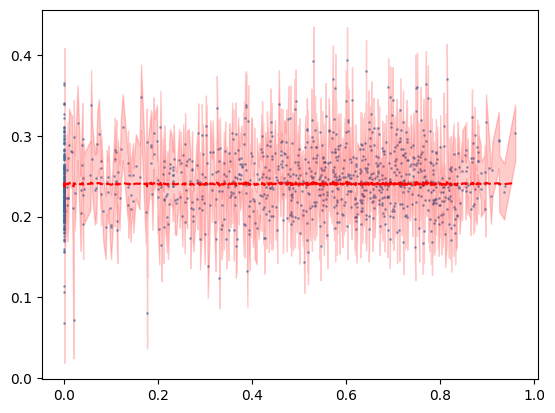

In [142]:
df = pd.DataFrame({'metric': metric_list, 'brightness': brightness_image_list})
df = df.sort_values(by='metric')
brightness = list(df["brightness"])
metric = list(df["metric"])


window_size = 100
rolling_std = df['brightness'].rolling(window_size, min_periods=100).std().values
z = np.polyfit(metric, brightness, 1)
p = np.poly1d(z)

plt.plot(metric, p(brightness), 'r--')
plt.scatter(metric,brightness, s=1, alpha=0.5)
plt.fill_between(metric, brightness-rolling_std, brightness+rolling_std, alpha=0.2, color='red', label='Rolling std')

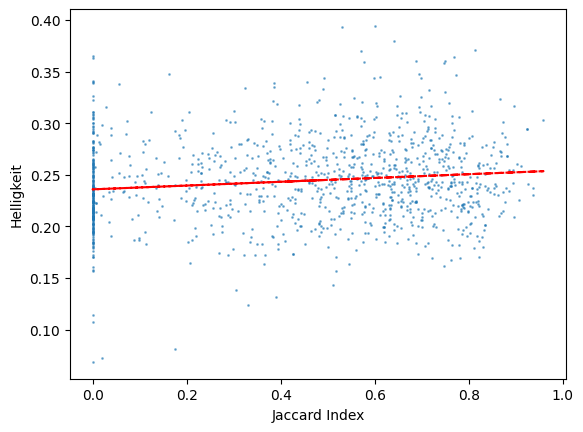

In [102]:
plt.scatter(metric_list, brightness_image_list, s=1, alpha=0.5)

p = np.polyfit(metric_list, brightness_image_list, 1)
y_fit = np.polyval(p, metric_list)

# Zeichnen Sie die Trendlinie
plt.plot(metric_list, y_fit, 'r--')
# Labeln Sie die Achsen
plt.ylabel('Helligkeit')
plt.xlabel('Jaccard Index')

# Zeigen Sie den Plot an
plt.show()

<Axes: >

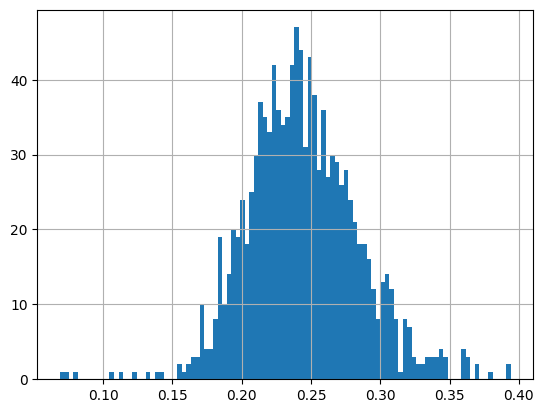

In [62]:
df.brightness.hist(bins=100)

<Axes: >

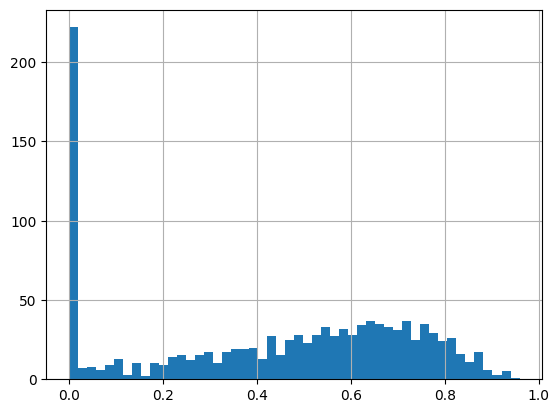

In [63]:
df.metric.hist(bins=50)

In [53]:
df_new

,index,metric,mask_size,brightness,pred_mask,img_path,mask_path
0,2982,0.0,477,0.2754759,"[[[0.042283975, 0.008992369, 0.007503625, 0.00...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
1,2823,0.0,379,0.20868641,"[[[0.032980222, 0.010971187, 0.013536464, 0.01...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
2,1159,0.0,465,0.27388045,"[[[0.034726404, 0.011333939, 0.01135993, 0.015...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
3,4347,0.0,1466,0.30594486,"[[[0.034051064, 0.0092744995, 0.01119626, 0.01...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
4,879,0.0,1931,0.22066079,"[[[0.0459067, 0.009705401, 0.010283612, 0.0096...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
...,...,...,...,...,...,...,...
1136,3861,0.9242986,1829,0.29417557,"[[[0.03551045, 0.008933377, 0.010964849, 0.011...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
1137,3878,0.92521846,7622,0.24084537,"[[[0.044657674, 0.014059813, 0.011699027, 0.01...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
1138,4053,0.936,2714,0.23084094,"[[[0.03572957, 0.0075167506, 0.00768276, 0.008...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
1139,3840,0.9375385,4620,0.23758888,"[[[0.18851054, 0.15886898, 0.3904268, 0.545922...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...


#### Show good performing images

In [39]:
def show_rgb_samples(sample):
    img = torch.load(sample.img_path)
    mask = torch.load(sample.mask_path)
    mask = torch.Tensor.numpy(mask).transpose((1,2,0))
    mask = mask[:,:,0]
    plt.figure(figsize=(8, 8))
    plt.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)))
    plt.imshow(mask, cmap='jet', alpha=0.5*(mask==True))

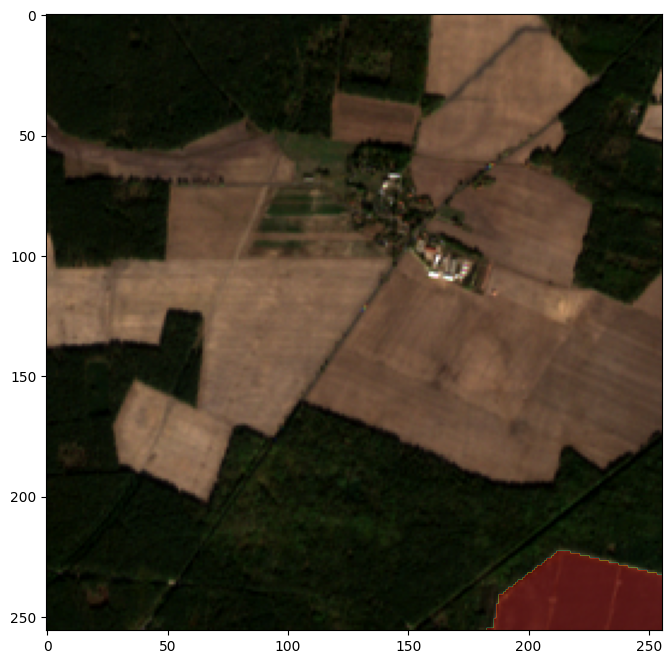

In [56]:
# 296
sample = df.iloc[1140]
img = torch.load(sample.img_path)
mask = torch.load(sample.mask_path)
mask = torch.Tensor.numpy(mask).transpose((1,2,0))
mask = mask[:,:,0]
pred = sample.pred_mask
plt.figure(figsize=(8, 8))
plt.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)))
plt.imshow(mask, cmap='jet', alpha=0.5*(mask==True));

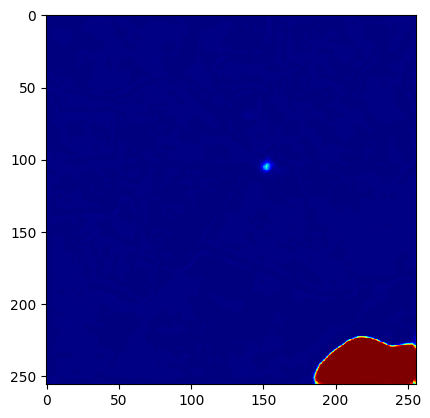

In [57]:
plt.imshow(pred[0,:,:], cmap='jet');

In [46]:
sample.img_path.name

'32UNE_447_2018-11-16.pt'

In [51]:
sample

index                                                      1154
metric                                                0.6101309
mask_size                                                  1567
brightness                                           0.23113611
pred_mask     [[[0.04032828, 0.008616758, 0.008594354, 0.010...
img_path      C:\Users\Fabian\Documents\Github_Masterthesis\...
mask_path     C:\Users\Fabian\Documents\Github_Masterthesis\...
Name: 128, dtype: object

In [296]:
mask = mask[:,:,0]

In [297]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

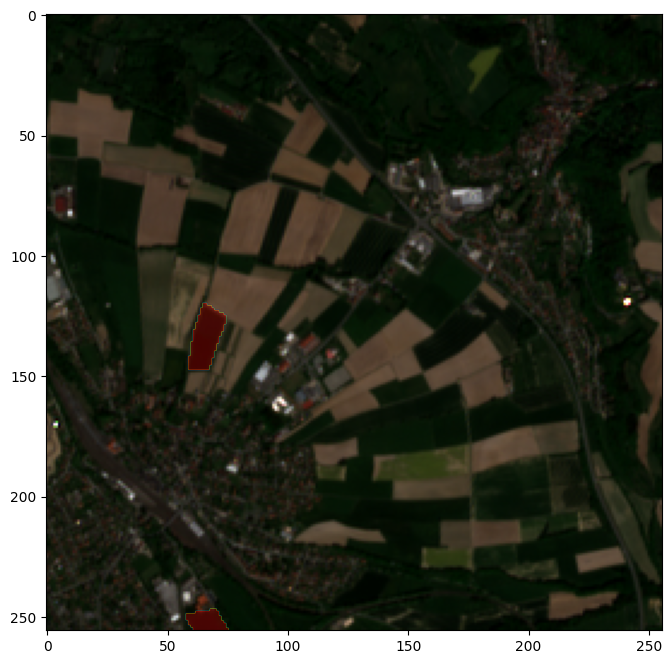

In [301]:
show_rgb_samples(df.iloc[913])

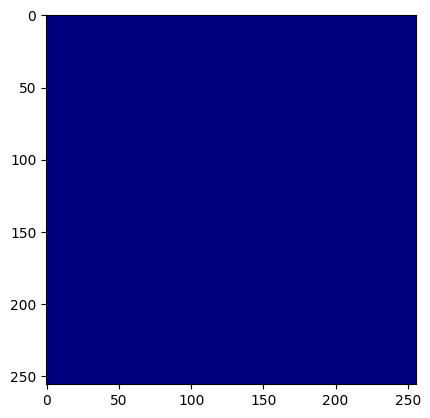

In [322]:
plt.imshow(pred[0,:,:]>0.5, cmap='jet')

In [314]:
plt.show(pred[])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

#### show the worst images

In [248]:
img_path = df.iloc[0]['img_path']

In [249]:
img_path

WindowsPath('C:/Users/Fabian/Documents/Github_Masterthesis/Solarpark-detection/data_local/data_splitted_undersampling/test/images/32UMD_105_2018-7-27.pt')

In [ ]:
def show_rgb_sample(sample):
    img, mask = sample
    plt.figure(figsize=(8, 8))
    plt.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)))
    plt.imshow(torch.Tensor.numpy(mask), cmap='jet', alpha=0.5*(torch.Tensor.numpy(mask)==True))

In [254]:
img = torch.load(img_path)

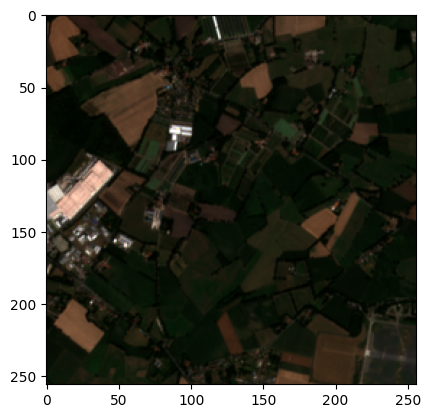

In [256]:
plt.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)));